## Загрузка зависимостей

In [2]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install scikit-learn
!pip install seaborn
!pip install imbalanced-learn

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from pandas.api.types import is_numeric_dtype
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
import re
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from collections import Counter

## Загрузка датасета

In [2]:
# загрузка датасета
df = pd.read_csv("heart_attack_prediction_dataset.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8763 entries, 0 to 8762
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Patient ID                       8763 non-null   object 
 1   Age                              8763 non-null   int64  
 2   Sex                              8763 non-null   object 
 3   Cholesterol                      8763 non-null   int64  
 4   Blood Pressure                   8763 non-null   object 
 5   Heart Rate                       8763 non-null   int64  
 6   Diabetes                         8763 non-null   int64  
 7   Family History                   8763 non-null   int64  
 8   Smoking                          8763 non-null   int64  
 9   Obesity                          8763 non-null   int64  
 10  Alcohol Consumption              8763 non-null   int64  
 11  Exercise Hours Per Week          8763 non-null   float64
 12  Diet                

In [5]:
# количество уникальных значений
df.nunique()

Patient ID                         8763
Age                                  73
Sex                                   2
Cholesterol                         281
Blood Pressure                     3915
Heart Rate                           71
Diabetes                              2
Family History                        2
Smoking                               2
Obesity                               2
Alcohol Consumption                   2
Exercise Hours Per Week            8763
Diet                                  3
Previous Heart Problems               2
Medication Use                        2
Stress Level                         10
Sedentary Hours Per Day            8763
Income                             8615
BMI                                8763
Triglycerides                       771
Physical Activity Days Per Week       8
Sleep Hours Per Day                   7
Country                              20
Continent                             6
Hemisphere                            2


## Чистка и проверка

In [3]:
# удаляем столбец id пациентов
df = df.drop("Patient ID", axis=1)

In [4]:
# разделим Blood Pressure на две колонки Systolic и Diastolic
df[['Systolic', 'Diastolic']] = df['Blood Pressure'] \
    .str.replace('"', '') \
    .str.split('/', expand=True)

# Преобразуем новые столбцы в числовой тип данных
df['Systolic'] = pd.to_numeric(df['Systolic'], errors='coerce')
df['Diastolic'] = pd.to_numeric(df['Diastolic'], errors='coerce')

# Вывод итогового DataFrame с новыми столбцами
print("датасет с разделёнными столбцами (Systolic и Diastolic):")
print(df.head())

датасет с разделёнными столбцами (Systolic и Diastolic):
   Age     Sex  Cholesterol Blood Pressure  Heart Rate  Diabetes  \
0   67    Male          208         158/88          72         0   
1   21    Male          389         165/93          98         1   
2   21  Female          324         174/99          72         1   
3   84    Male          383        163/100          73         1   
4   66    Male          318          91/88          93         1   

   Family History  Smoking  Obesity  Alcohol Consumption  ...        BMI  \
0               0        1        0                    0  ...  31.251233   
1               1        1        1                    1  ...  27.194973   
2               0        0        0                    0  ...  28.176571   
3               1        1        0                    1  ...  36.464704   
4               1        1        1                    0  ...  21.809144   

  Triglycerides  Physical Activity Days Per Week  Sleep Hours Per Day  \
0   

In [5]:
# удалим давление крови
df = df.drop("Blood Pressure", axis=1)

In [6]:
#удаляем так же Страну, Полушарие
df = df.drop("Country", axis=1)
df = df.drop("Continent", axis=1)

In [7]:
# проверка на дубликаты
df.drop_duplicates()

,Age,Sex,Cholesterol,Heart Rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,...,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Hemisphere,Heart Attack Risk,Systolic,Diastolic
0,67,Male,208,72,0,0,1,0,0,4.168189,...,6.615001,261404,31.251233,286,0,6,Southern Hemisphere,0,158,88
1,21,Male,389,98,1,1,1,1,1,1.813242,...,4.963459,285768,27.194973,235,1,7,Northern Hemisphere,0,165,93
2,21,Female,324,72,1,0,0,0,0,2.078353,...,9.463426,235282,28.176571,587,4,4,Northern Hemisphere,0,174,99
3,84,Male,383,73,1,1,1,0,1,9.828130,...,7.648981,125640,36.464704,378,3,4,Northern Hemisphere,0,163,100
4,66,Male,318,93,1,1,1,1,0,5.804299,...,1.514821,160555,21.809144,231,1,5,Northern Hemisphere,0,91,88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8758,60,Male,121,61,1,1,1,0,1,7.917342,...,10.806373,235420,19.655895,67,7,7,Northern Hemisphere,0,94,76
8759,28,Female,120,73,1,0,0,1,0,16.558426,...,3.833038,217881,23.993866,617,4,9,Northern Hemisphere,0,157,102
8760,47,Male,250,105,0,1,1,1,1,3.148438,...,2.375214,36998,35.406146,527,4,4,Southern Hemisphere,1,161,75
8761,36,Male,178,60,1,0,1,0,0,3.789950,...,0.029104,209943,27.294020,114,2,8,Southern Hemisphere,0,119,67


In [11]:
# проверка на пустые значения
df.isnull()

,Age,Sex,Cholesterol,Heart Rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,...,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Hemisphere,Heart Attack Risk,Systolic,Diastolic
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8758,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8759,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8760,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8761,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


# Кодируем категориальные данные

In [8]:
# кодируем категориальные параметры
sex = LabelEncoder()
diet = LabelEncoder()
hemisphere = LabelEncoder()


df['Sex_Code'] = sex.fit_transform(df['Sex'])
df['Diet_Code'] = diet.fit_transform(df['Diet'])
df['Hemisphere_Code'] = hemisphere.fit_transform(df['Hemisphere'])

In [9]:
print("\nКодирование для Sex:")
for code, label in enumerate(sex.classes_):
    print(f"{label}: {code}")

print("\nКодирование для Diet:")
for code, label in enumerate(diet.classes_):
    print(f"{label}: {code}")

print("\nКодирование для Hemisphere:")
for code, label in enumerate(hemisphere.classes_):
    print(f"{label}: {code}")


Кодирование для Sex:
Female: 0
Male: 1

Кодирование для Diet:
Average: 0
Healthy: 1
Unhealthy: 2

Кодирование для Hemisphere:
Northern Hemisphere: 0
Southern Hemisphere: 1


## Анализ

In [59]:
def compare_two_feature(attr_one, attr_two, dataframe):
    risk_by_attr = dataframe.groupby([attr_one, attr_two]).size().unstack(fill_value=0)
    risk_by_attr_percentage = risk_by_attr.div(risk_by_attr.sum(axis=1), axis=0) * 100
    risk_by_attr_percentage = risk_by_attr_percentage.applymap(lambda x: f"{x:.2f}%")
    print(risk_by_attr_percentage)

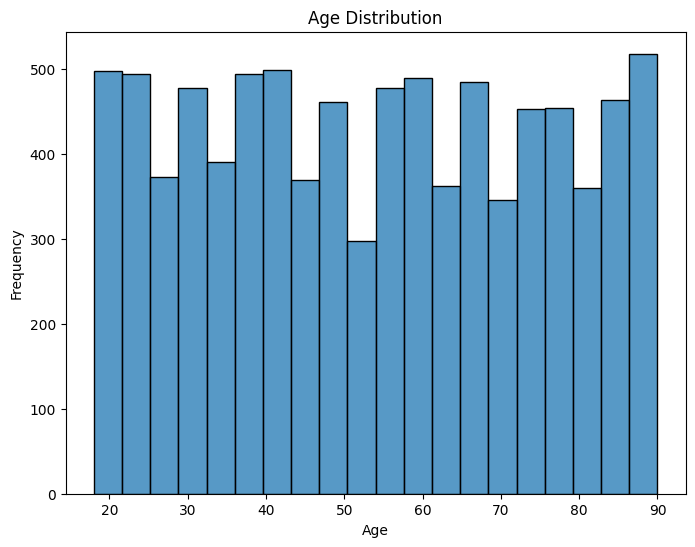

In [11]:
# Age распределение
plt.figure(figsize=(8, 6))
sns.histplot(df['Age'], kde=False, bins=20)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

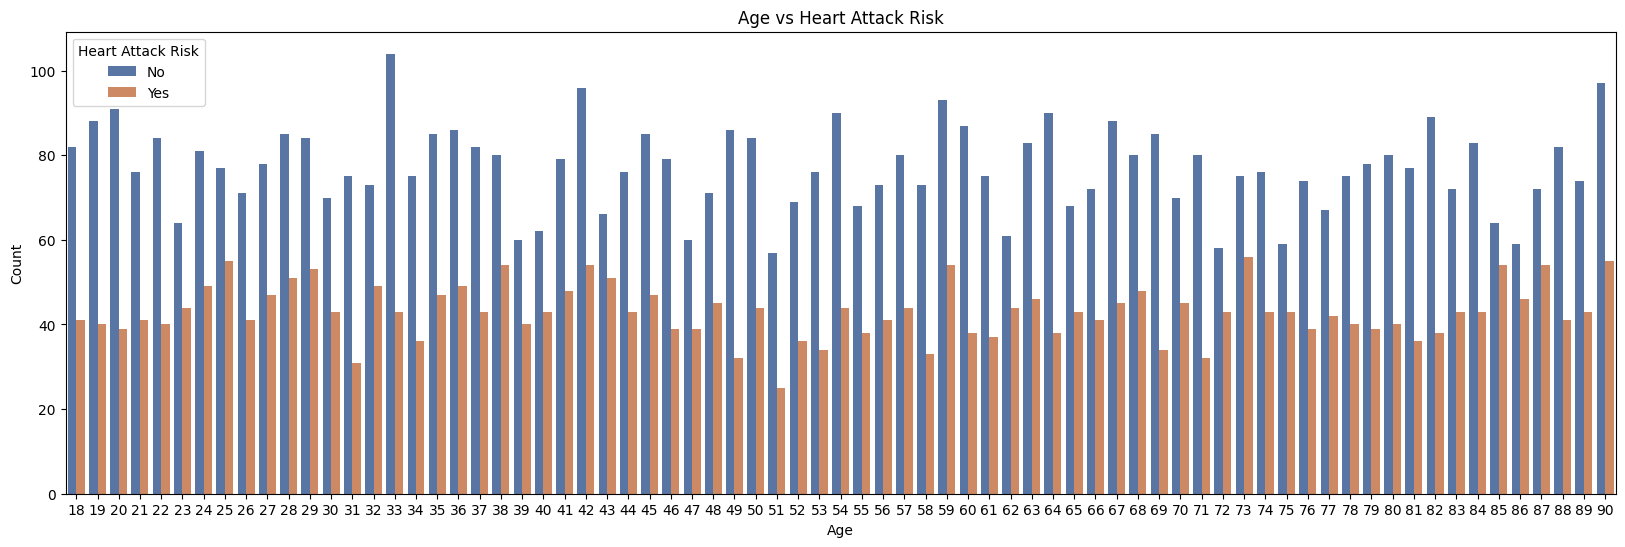

In [12]:
# Age и Heart Attack Risk
plt.figure(figsize=(20, 6))
sns.countplot(data=df, x='Age', hue='Heart Attack Risk', palette='deep')
plt.title('Age vs Heart Attack Risk')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend(title='Heart Attack Risk', labels=['No', 'Yes'])
plt.show()


In [62]:
# выведем отношение у каждой категории возраста где риск больше 40%
risk_by_age = df.groupby(['Age', 'Heart Attack Risk']).size().unstack(fill_value=0)
risk_by_age_percentage = risk_by_age.div(risk_by_age.sum(axis=1), axis=0) * 100
risk_by_age_percentage = risk_by_age_percentage.applymap(lambda x: f"{x:.2f}%")
filtered_result = risk_by_age_percentage[risk_by_age_percentage[1].str.rstrip('%').astype(float) > 40]
pd.set_option('display.max_rows', None)
print(filtered_result)

pd.reset_option('display.max_rows')

Heart Attack Risk       0       1
Age                              
23                 59.26%  40.74%
25                 58.33%  41.67%
32                 59.84%  40.16%
38                 59.70%  40.30%
40                 59.05%  40.95%
43                 56.41%  43.59%
62                 58.10%  41.90%
72                 57.43%  42.57%
73                 57.25%  42.75%
75                 57.84%  42.16%
85                 54.24%  45.76%
86                 56.19%  43.81%
87                 57.14%  42.86%


/tmp/ipykernel_6202/288867739.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  risk_by_age_percentage = risk_by_age_percentage.applymap(lambda x: f"{x:.2f}%")


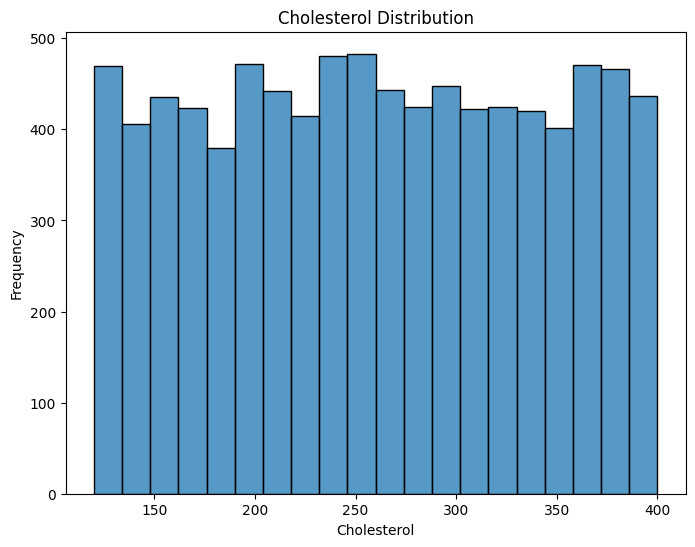

In [21]:
# Распределение Cholesterol
plt.figure(figsize=(8, 6))
sns.histplot(df['Cholesterol'], kde=False, bins=20)
plt.title('Cholesterol Distribution')
plt.xlabel('Cholesterol')
plt.ylabel('Frequency')
plt.show()

<Axes: xlabel='Cholesterol', ylabel='Count'>

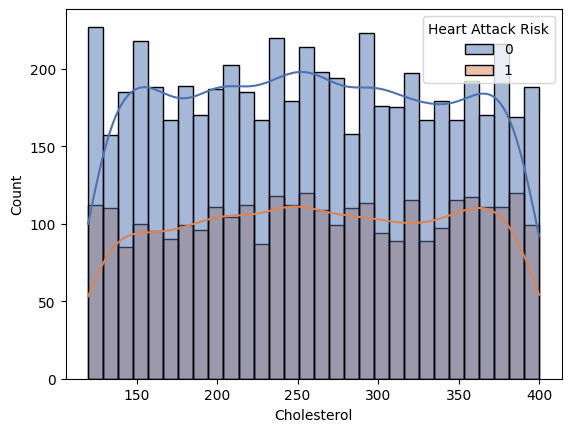

In [22]:
# Cholesterol и Heart Attack
sns.histplot(data=df, x='Cholesterol', hue='Heart Attack Risk', kde=True, palette='deep', bins=30)

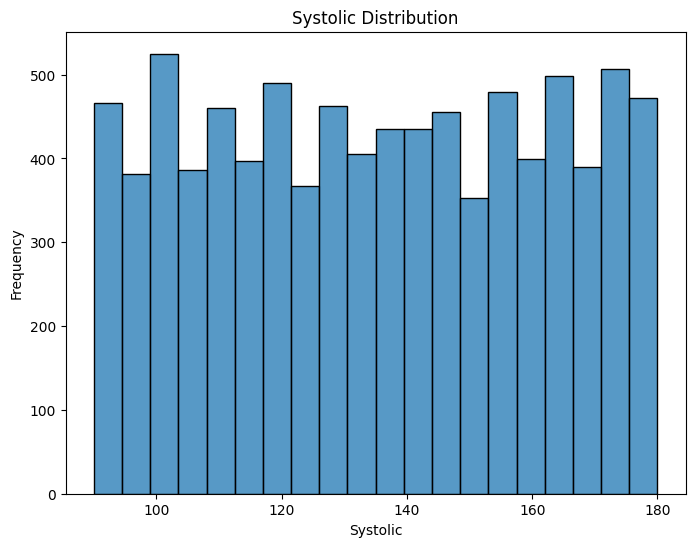

In [23]:
# систолическое давление
plt.figure(figsize=(8, 6))
sns.histplot(df['Systolic'], kde=False, bins=20)
plt.title('Systolic Distribution')
plt.xlabel('Systolic')
plt.ylabel('Frequency')
plt.show()

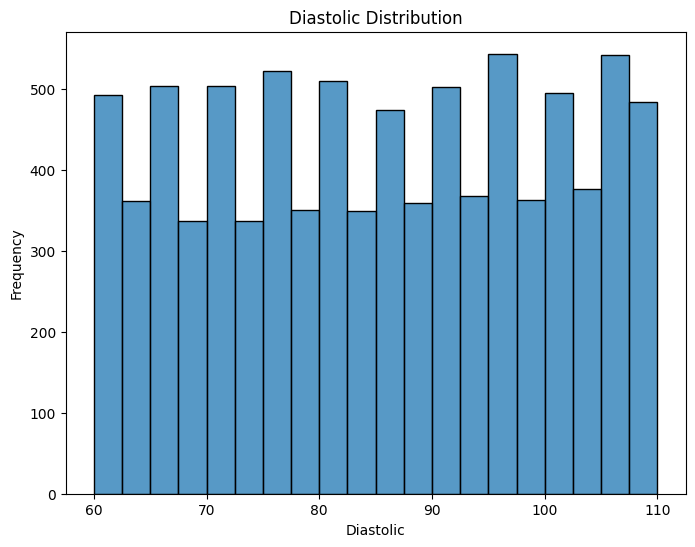

In [24]:
#диастолическое давление
plt.figure(figsize=(8, 6))
sns.histplot(df['Diastolic'], kde=False, bins=20)
plt.title('Diastolic Distribution')
plt.xlabel('Diastolic')
plt.ylabel('Frequency')
plt.show()

/tmp/ipykernel_6202/2614858445.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Heart Attack Risk', y=ratio, palette='deep')


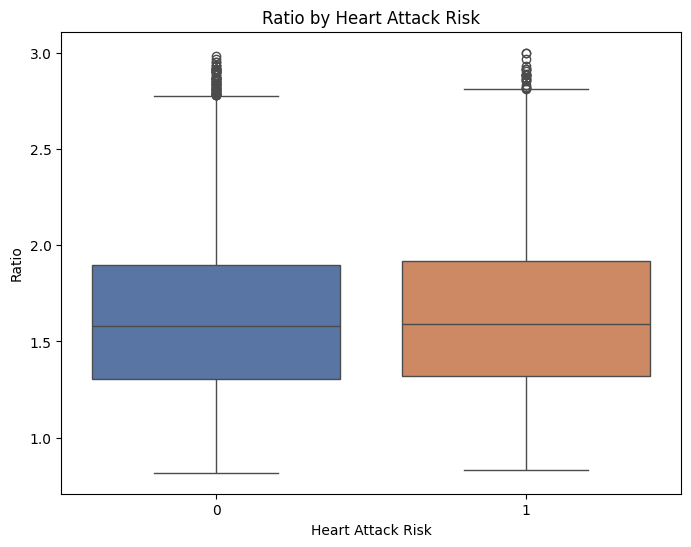

In [25]:
# распределение кровяного давления
ratio = df['Systolic'] / df['Diastolic']

plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='Heart Attack Risk', y=ratio, palette='deep')

plt.title('Ratio by Heart Attack Risk')
plt.xlabel('Heart Attack Risk')
plt.ylabel('Ratio')
plt.show()

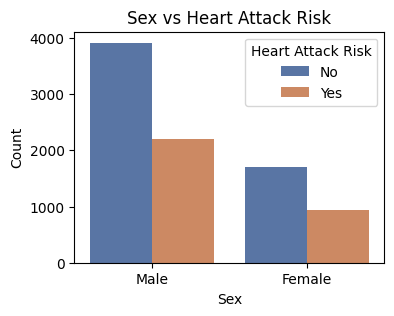

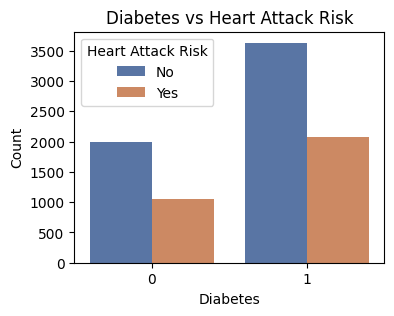

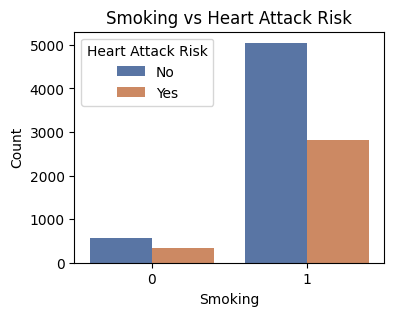

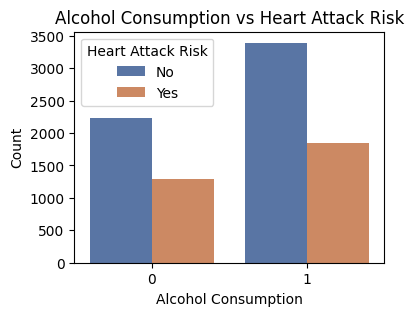

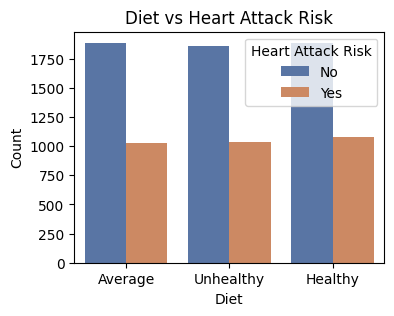

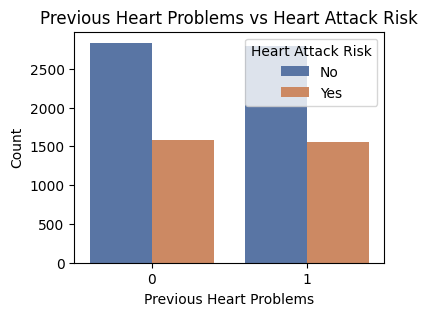

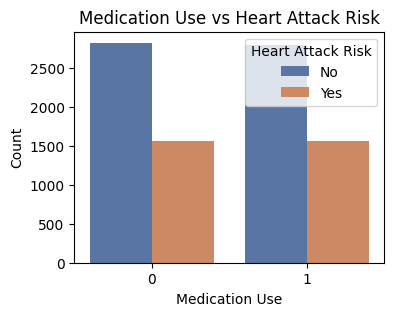

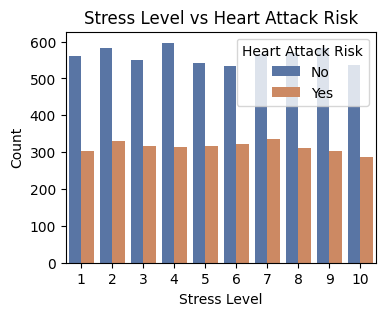

In [54]:
attrs = ['Sex', 'Diabetes', 'Smoking', 'Alcohol Consumption', 'Diet', 'Previous Heart Problems', 'Medication Use', 'Stress Level']

for a in attrs:
    plt.figure(figsize=(4, 3))
    sns.countplot(data=df, x=a, hue='Heart Attack Risk', palette='deep')
    plt.title(a + ' vs Heart Attack Risk')
    plt.xlabel(a)
    plt.ylabel('Count')
    plt.legend(title='Heart Attack Risk', labels=['No', 'Yes'])
    plt.show()

In [63]:
for attr in attrs:
    compare_two_feature(attr, 'Heart Attack Risk', df)
    print('')

Heart Attack Risk       0       1
Sex                              
Female             64.40%  35.60%
Male               64.08%  35.92%

Heart Attack Risk       0       1
Diabetes                         
0                  65.31%  34.69%
1                  63.58%  36.42%

Heart Attack Risk       0       1
Smoking                          
0                  63.61%  36.39%
1                  64.24%  35.76%

Heart Attack Risk         0       1
Alcohol Consumption                
0                    63.37%  36.63%
1                    64.72%  35.28%

Heart Attack Risk       0       1
Diet                             
Average            64.77%  35.23%
Healthy            63.55%  36.45%
Unhealthy          64.23%  35.77%

Heart Attack Risk             0       1
Previous Heart Problems                
0                        64.19%  35.81%
1                        64.17%  35.83%

Heart Attack Risk       0       1
Medication Use                   
0                  64.29%  35.71%
1         

/tmp/ipykernel_6202/471988331.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  risk_by_attr_percentage = risk_by_attr_percentage.applymap(lambda x: f"{x:.2f}%")
/tmp/ipykernel_6202/471988331.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  risk_by_attr_percentage = risk_by_attr_percentage.applymap(lambda x: f"{x:.2f}%")
/tmp/ipykernel_6202/471988331.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  risk_by_attr_percentage = risk_by_attr_percentage.applymap(lambda x: f"{x:.2f}%")
/tmp/ipykernel_6202/471988331.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  risk_by_attr_percentage = risk_by_attr_percentage.applymap(lambda x: f"{x:.2f}%")
/tmp/ipykernel_6202/471988331.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  risk_by_attr_percentage = risk_by_attr_percentage.applymap(lambda x: f"{